### Parallelised Monte Carlo Simulation of Markov Model in Health Economics

### Import the required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

### Define the MarkovModel Class

In [2]:
class MarkovModel:
    def __init__(self, transition_matrix, costs):
        self.transition_matrix = transition_matrix
        self.states = [0] * len(self.transition_matrix)
        self.states[0] = 300000  # Population with the combination of factors
        self.total_cost = 0
        self.insurance_premium = 135 # Monthly insurance premium
        
    def run_simulation(self, cycles):
        self.costs_over_time = []  
        
        for cycle in range(cycles):
            next_states = [0] * len(self.transition_matrix)
            
            for i, prob in enumerate(self.transition_matrix):
                transitions = np.random.multinomial(self.states[i], prob)
                for j, count in enumerate(transitions):
                    next_states[j] += count
            
            next_states[0] += np.random.poisson(10000) # Simulate people being diagnosed with the disease over time i.e. prevalence (to account for people leaving the system by death)
            
            self.total_cost += sum([state * cost for state, cost in zip(self.states, costs)])
            total_premiums = sum(self.states[:-1]) * self.insurance_premium  
            self.total_cost -= total_premiums
            
            self.states = next_states
            
            self.costs_over_time.append(self.total_cost)
            
            self.insurance_premium *= 1.05 # Assume that the insurance premium increases by 5% per year


### Set-up the Transition Matrix

In [3]:
# Adding costs for the new states
costs = [0, 50, 0, 1000, 5000, 0, 0, 0]  # Costs per state in the Markov Model.

def get_transition_matrix_A(p_adverse1, p_adverse2):
    p_death = 0.01 # probability of death set to 1%
    p_stay = 1 - (p_death + p_adverse1 + p_adverse2) # probability of staing in a particular state adjusted for the te
    
    return [
        [0, p_stay, 0, p_adverse1, p_adverse2, p_death],
        [0, 0.87 - (0.05 * 2), 0, 0.05 * 3, 0.05, 0.03],
        [0, 0, 0.82 - (0.08 + 0.07), 0.08 * 2, 0.07 * 2, 0.03],
        [0, 0.9, 0, 0.1, 0, 0],
        [0, 0.7, 0, 0, 0.3, 0],
        [0, 0, 0, 0, 0, 1],
    ]

def get_transition_matrix_B(p_adverse1, p_adverse2):
    p_death = 0.01
    p_stay = 1 - (p_death + p_adverse1 + p_adverse2)
    
    return [
        [0,  p_stay, 0, p_adverse1, p_adverse2, p_death],
        [0, 0.87 - (0.05 * 2), 0, 0.05 * 3, 0.05, 0.03],
        [0, 0, 0.82 - (0.08 + 0.07), 0.08 * 2, 0.07 * 2, 0.03],
        [0, 0.9, 0, 0.1, 0, 0],
        [0, 0.7, 0, 0, 0.3, 0],
        [0, 0, 0, 0, 0, 1],
    ]

### Simulation Functions

In [6]:
def simulate_treatment_A_chunk(chunk_size):
    results = []
    for _ in range(chunk_size):
        # [Initialize and run model_A within this scope]
        # Generate random probabilities for adverse events specific to Treatment A
        p_adverse1_A_var = np.clip(np.random.normal(0.00131, 0.0005), 0, 1)
        p_adverse2_A_var = np.clip(np.random.normal(0.0212, 0.0005), 0, 1)

        # Generate a custom transition matrix for Treatment A based on the probabilities
        transition_A_var = get_transition_matrix_A(p_adverse1_A_var, p_adverse2_A_var)
        
        # Create a MarkovModel instance for Treatment A and run a simulation for 20 years
        model_A = MarkovModel(transition_A_var, costs)
        model_A.run_simulation(20)
        
        # Append the final cost from the simulation to the results list
        results.append(model_A.costs_over_time[-1])
    return results

def simulate_treatment_B_chunk(chunk_size):
    results = []
    for _ in range(chunk_size):
        # [Initialize and run model_B within this scope]
        # Generate random probabilities for adverse events specific to Treatment B
        p_adverse1_B_var = np.clip(np.random.normal(0.0123, 0.0005), 0, 1)
        p_adverse2_B_var = np.clip(np.random.normal(0.0323, 0.0005), 0, 1)

        # Generate a custom transition matrix for Treatment B based on the probabilities
        transition_B_var = get_transition_matrix_B(p_adverse1_B_var, p_adverse2_B_var)
        
        # Create a MarkovModel instance for Treatment B and run a simulation for 20 years
        model_B = MarkovModel(transition_B_var, costs)
        model_B.run_simulation(20)
        
        # Append the final cost from the simulation to the results list
        results.append(model_B.costs_over_time[-1])
    return results

N_SIMULATIONS = 5000000  # Adjust based on your requirements
CHUNK_SIZE = 1000  # Adjust based on your requirements
N_WORKERS = 64 # Ajust based on your requirements

# Use concurrent processing to run simulations in parallel

with concurrent.futures.ProcessPoolExecutor(max_workers=N_WORKERS) as executor:
    future_results_A = [executor.submit(simulate_treatment_A_chunk, CHUNK_SIZE) for _ in range(N_SIMULATIONS // CHUNK_SIZE)]
    future_results_B = [executor.submit(simulate_treatment_B_chunk, CHUNK_SIZE) for _ in range(N_SIMULATIONS // CHUNK_SIZE)]
    
    results_A = [result for future in future_results_A for result in future.result()]
    results_B = [result for future in future_results_B for result in future.result()]

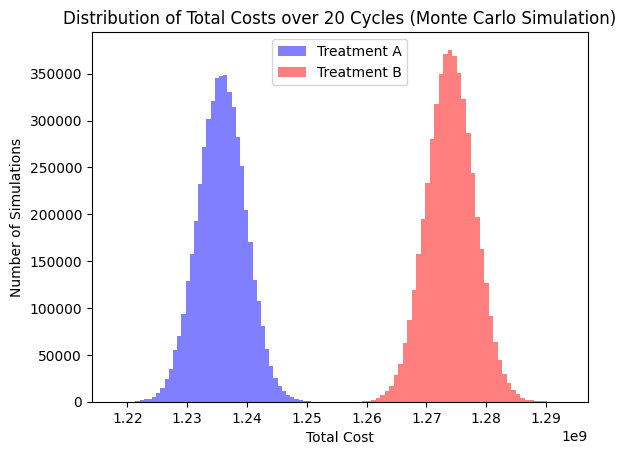

Average cost for Treatment A: €1.24 billion
Average cost for Treatment B: €1.27 billion


In [7]:
# Visualizing Results
plt.hist(results_A, bins=50, alpha=0.5, label="Treatment A", color='blue')
plt.hist(results_B, bins=50, alpha=0.5, label="Treatment B", color='red')
plt.xlabel("Total Cost")
plt.ylabel("Number of Simulations")
plt.title("Distribution of Total Costs over 20 Cycles (Monte Carlo Simulation)")
plt.legend()
plt.show()

print(f"Average cost for Treatment A: €{np.mean(results_A)/1e9:,.2f} billion")
print(f"Average cost for Treatment B: €{np.mean(results_B)/1e9:,.2f} billion")